In [1]:
import gymnasium as gym
import numpy as np
import ochre_gym

# 1) Load env
env = ochre_gym.load(
    "basic-v0",  # Specifies the base residential building model (HPXML) provided by OCHRE

    override_equipment_controls={"HVAC Heating": ["Setpoint"]},  
    # Defines which device(s) can be controlled by the RL agent.
    # Here, the heating system's thermostat setpoint is exposed as the control variable.

    vectorize_actions=True,  
    # Converts action inputs to a flattened numeric vector for compatibility with RL libraries.

    vectorize_observations=True,  
    # Flattens observation outputs (state variables) into a single numeric vector.

    override_ochre_observations_with_keys=[
        "Temperature - Indoor (C)",   # Indoor air temperature from OCHRE simulation
        "Temperature - Outdoor (C)",  # Outdoor temperature from weather data
        "Energy Price ($)",           # Real-time or time-of-use electricity price
        "Hour of Day",                # Time feature for temporal learning in RL
    ],
    # Restricts the observation space to these selected variables, simplifying the state representation.

    start_time="2018-01-01 00:00:00",
    end_time  ="2018-01-03 23:30:00",
    # Defines the start and end time of the OCHRE simulation period.

    time_res="00:30",  
    # Simulation timestep: 30 minutes per control action.

    lookahead="00:30",   
    # Defines the energy price forecast horizon used in reward computation.
    # Must be a multiple of time_res (e.g., 00:30, 01:00, etc.).

    dr_type="TOU",  
    # Selects the demand response pricing scheme: 
    # RTP = Real-Time Pricing, TOU = Time-of-Use, PC = Peak-Critical.

    reward_normalization=True,  
    # Normalizes reward values to improve numerical stability during RL training.

    thermal_comfort_band=[20.0, 23.0],  
    # Defines the acceptable indoor temperature range (comfort zone in °C).

    thermal_comfort_unit_penalty=10,  
    # Penalty weight applied per °C deviation from the comfort band.
    # Higher values enforce tighter comfort adherence.

    log_to_file=False,  
    log_to_console=False,  
    # Controls logging output; disabling keeps the console clean during simulation.
)

# 2) Discretize the heating setpoint (e.g., 7 actions from 20.0 to 23.0 by 0.5°C)
SETPOINTS = np.round(np.arange(20.0, 23.0 + 0.001, 0.5), 1)  # Creates discrete setpoints: [20.0, 20.5, ..., 23.0]
A = len(SETPOINTS)  # Total number of discrete actions available to the agent

class HeatingSetpointDiscrete(gym.ActionWrapper):
    """
    Wrapper class to convert discrete action indices (0, 1, 2, ...) 
    into continuous temperature setpoint values expected by the OCHRE environment.
    """
    def __init__(self, env, setpoints):
        super().__init__(env)
        self.setpoints = np.array(setpoints, dtype=np.float32)
        # The OCHRE environment expects actions as vectors because vectorize_actions=True.
        # Since we only control heating setpoint, the action vector has length 1.
        self.action_space = gym.spaces.Discrete(len(self.setpoints))  
        # Defines a discrete action space where each integer corresponds to one temperature setpoint.

    def action(self, a_idx):
        # Maps the discrete action index to the actual setpoint value.
        sp = self.setpoints[a_idx]
        # Returns the action as a 1-element vector for compatibility with OCHRE-Gym.
        return np.array([sp], dtype=np.float32)

# Wrap the environment so that the RL agent can choose from discrete setpoint indices.
env = HeatingSetpointDiscrete(env, SETPOINTS)


In [2]:
# Bins per feature (tune these):
Tin_bins  = np.arange(18.0, 26.5, 0.5)   # Defines bins for indoor temperature from 18.0°C to 26.5°C in 0.5°C increments.
Tout_bins = np.arange(-20.0, 45.0, 5.0)  # Defines bins for outdoor temperature from -20°C to 45°C in 5°C increments.
Price_bins = np.array([0.0, 0.1, 0.2, 0.4, 1.0, 5.0])  # Defines price tiers (in $/kWh) representing different electricity cost levels.
Hour_bins  = np.arange(0, 24 + 1, 3)     # Divides the 24-hour day into 8 bins, each spanning 3 hours.

# Combine all bin definitions into a single list for iteration.
BIN_EDGES = [Tin_bins, Tout_bins, Price_bins, Hour_bins]


def discretize(obs_vec):
    """
    Converts a continuous observation vector into discrete bin indices 
    for use in a tabular Q-learning algorithm.

    Each feature (indoor temp, outdoor temp, price, hour) is assigned 
    to the index of the bin it falls into.
    """

    # Observation order must match the list defined in override_ochre_observations_with_keys
    # Example: ["Temperature - Indoor (C)", "Temperature - Outdoor (C)", "Energy Price ($)", "Hour of Day"]
    tin, tout, price, hour = obs_vec[0], obs_vec[1], obs_vec[2], obs_vec[3]

    # Group the observation values for iteration
    vals = [tin, tout, price, hour]

    # Initialize list to store the bin index for each feature
    idxs = []

    # Loop over each value and its corresponding bin edges
    for v, edges in zip(vals, BIN_EDGES):
        # np.digitize returns a bin number starting from 1 up to len(edges)
        # (right=False) means each bin includes its left edge and excludes the right edge: [a_i, a_{i+1})
        i = int(np.digitize(v, edges, right=False))

        # Clamp the index so it's always within valid bounds (0 to len(edges))
        # This prevents errors when values fall outside the defined bin ranges.
        i = max(0, min(i, len(edges)))

        # Add the bin index to the list
        idxs.append(i)

    # Return a tuple of bin indices (e.g., (7, 9, 2, 5))
    # Tuples are hashable, meaning they can be used as keys in a Q-table dictionary.
    return tuple(idxs)


Episode 01 | steps=144 | return=-418.79
Episode 02 | steps=144 | return=-431.35
Episode 03 | steps=144 | return=-415.32
Episode 04 | steps=144 | return=-427.55
Episode 05 | steps=144 | return=-432.12
Episode 06 | steps=144 | return=-434.56
Episode 07 | steps=144 | return=-421.48
Episode 08 | steps=144 | return=-411.05
Episode 09 | steps=144 | return=-421.74
Episode 10 | steps=144 | return=-411.24
Episode 11 | steps=144 | return=-420.29
Episode 12 | steps=144 | return=-433.11
Episode 13 | steps=144 | return=-423.26
Episode 14 | steps=144 | return=-435.89
Episode 15 | steps=144 | return=-419.23
Episode 16 | steps=144 | return=-439.44
Episode 17 | steps=144 | return=-421.19
Episode 18 | steps=144 | return=-425.66
Episode 19 | steps=144 | return=-429.46
Episode 20 | steps=144 | return=-421.99
Episode 21 | steps=144 | return=-421.41
Episode 22 | steps=144 | return=-415.70
Episode 23 | steps=144 | return=-419.58
Episode 24 | steps=144 | return=-417.25
Episode 25 | steps=144 | return=-424.94


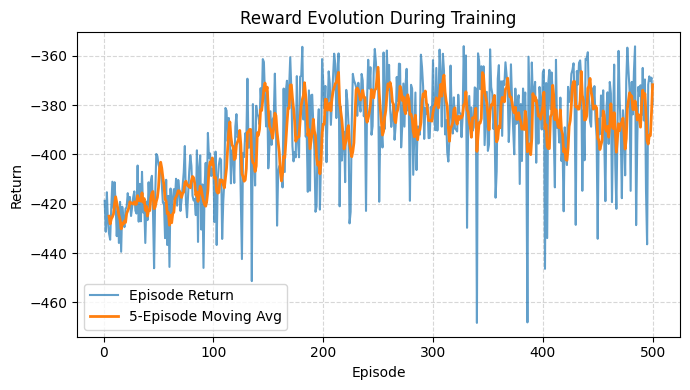

In [3]:
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt

# ---------------------------- #
# Helper: get hour from info
# ---------------------------- #
def get_hour_from_info(info):
    """Extracts hour of day from env info."""
    dt = info.get("Datetime", None)
    if dt is None:
        return 0.0
    if isinstance(dt, str):
        dt = pd.to_datetime(dt)
    return float(dt.hour)

# ---------------------------- #
# Safe discretizer (handles 3 or 4 features)
# ---------------------------- #
def discretize_safe(obs_vec, info=None):
    """Discretizes continuous observations to bins. Adds Hour if missing."""
    obs_vec = np.asarray(obs_vec).ravel()

    # If "Hour of Day" is missing from obs, derive it from info
    if obs_vec.shape[0] == 3:
        hour = 0.0 if info is None else get_hour_from_info(info)
        obs_vec = np.concatenate([obs_vec, [hour]])
    elif obs_vec.shape[0] != 4:
        raise ValueError(f"Expected 3 or 4 features, got shape {obs_vec.shape}")

    tin, tout, price, hour = obs_vec
    vals = [tin, tout, price, hour]
    idxs = []
    for v, edges in zip(vals, BIN_EDGES):
        i = int(np.digitize(v, edges, right=False))
        i = max(0, min(i, len(edges)))
        idxs.append(i)
    return tuple(idxs)

# ---------------------------- #
# Q-learning Hyperparameters
# ---------------------------- #
alpha = 0.2
gamma = 0.99
eps_start, eps_end, eps_decay = 1.0, 0.05, 20_000
episodes = 500
max_steps = 2000

Q = defaultdict(lambda: np.zeros(A, dtype=np.float32))

def epsilon(step):
    frac = max(0.0, 1.0 - step / eps_decay)
    return eps_end + (eps_start - eps_end) * frac

global_step = 0
ep_returns = []  # <--- store returns for plotting

# ---------------------------- #
# Q-learning training loop
# ---------------------------- #
for ep in range(episodes):
    obs, info = env.reset()
    s = discretize_safe(obs, info)
    ep_return = 0.0

    for t in range(max_steps):
        e = epsilon(global_step)
        if np.random.rand() < e:
            a = np.random.randint(A)      # explore
        else:
            a = int(np.argmax(Q[s]))      # exploit

        next_obs, r, terminated, truncated, info = env.step(a)
        s_next = discretize_safe(next_obs, info)

        best_next = np.max(Q[s_next])
        td_target = r + gamma * best_next
        td_error  = td_target - Q[s][a]
        Q[s][a]  += alpha * td_error

        s = s_next
        ep_return += r
        global_step += 1

        if terminated or truncated:
            break

    ep_returns.append(ep_return)
    print(f"Episode {ep+1:02d} | steps={t+1} | return={ep_return:.2f}")

# ---------------------------- #
# Plot reward evolution
# ---------------------------- #
def moving_avg(x, k=5):
    if k <= 1:
        return np.asarray(x, dtype=float)
    x = np.asarray(x, dtype=float)
    w = np.ones(k) / k
    return np.convolve(x, w, mode="valid")

episodes_idx = np.arange(1, len(ep_returns) + 1)
plt.figure(figsize=(7, 4))
plt.plot(episodes_idx, ep_returns, label="Episode Return", alpha=0.7)
ma = moving_avg(ep_returns, k=5)
plt.plot(np.arange(5, len(ep_returns) + 1), ma, label="5-Episode Moving Avg", linewidth=2)
plt.xlabel("Episode")
plt.ylabel("Return")
plt.title("Reward Evolution During Training")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


In [4]:
obs, info = env.reset()
s = discretize_safe(obs, info)   # <-- use the safe version
total = 0.0

for t in range(2000):
    a = int(np.argmax(Q[s]))     # greedy action (ε = 0)
    obs, r, terminated, truncated, info = env.step(a)
    s = discretize_safe(obs, info)  # <-- safe again
    total += r
    if terminated or truncated:
        break

print("Evaluation return:", total)


Evaluation return: -354.29154388317136


In [5]:
import numpy as np

def get_action_index_for_setpoint(target_sp, setpoints):
    """Find the discrete action index closest to a given setpoint value."""
    return int(np.argmin(np.abs(setpoints - target_sp)))

def evaluate_policy(env, Q, episodes=1, greedy=True):
    """Evaluate either the trained RL policy (greedy) or baseline control."""
    totals = []

    for ep in range(episodes):
        obs, info = env.reset()
        s = discretize_safe(obs, info)
        total = 0.0

        for t in range(2000):
            if greedy:
                a = int(np.argmax(Q[s]))  # greedy (best learned action)
            else:
                # baseline: fixed action (e.g., 21°C)
                baseline_idx = get_action_index_for_setpoint(21, SETPOINTS)
                a = baseline_idx

            obs, r, terminated, truncated, info = env.step(a)
            s = discretize_safe(obs, info)
            total += r
            if terminated or truncated:
                break

        totals.append(total)
        print(f"Episode {ep+1:02d} | return={total:.2f}")

    return np.mean(totals)

# --- Run both evaluations ---
rl_return = evaluate_policy(env, Q, episodes=3, greedy=True)
baseline_return = evaluate_policy(env, Q, episodes=3, greedy=False)

print("\nAverage returns over 3 eval episodes:")
print(f"RL Policy:     {rl_return:.2f}")
print(f"Baseline (21°C): {baseline_return:.2f}")
print(f"Improvement:   {rl_return - baseline_return:.2f}")


Episode 01 | return=-354.29
Episode 02 | return=-354.29
Episode 03 | return=-354.29
Episode 01 | return=-366.40
Episode 02 | return=-366.40
Episode 03 | return=-366.40

Average returns over 3 eval episodes:
RL Policy:     -354.29
Baseline (21°C): -366.40
Improvement:   12.11


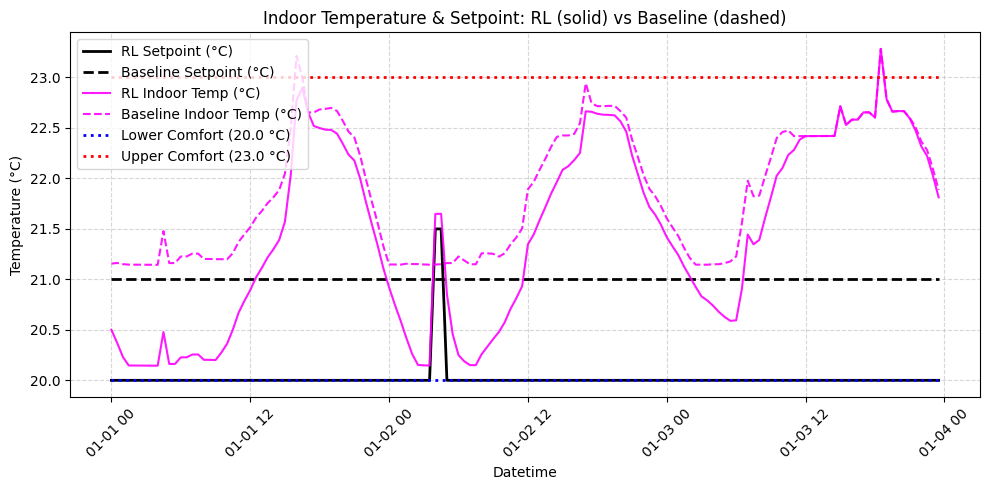

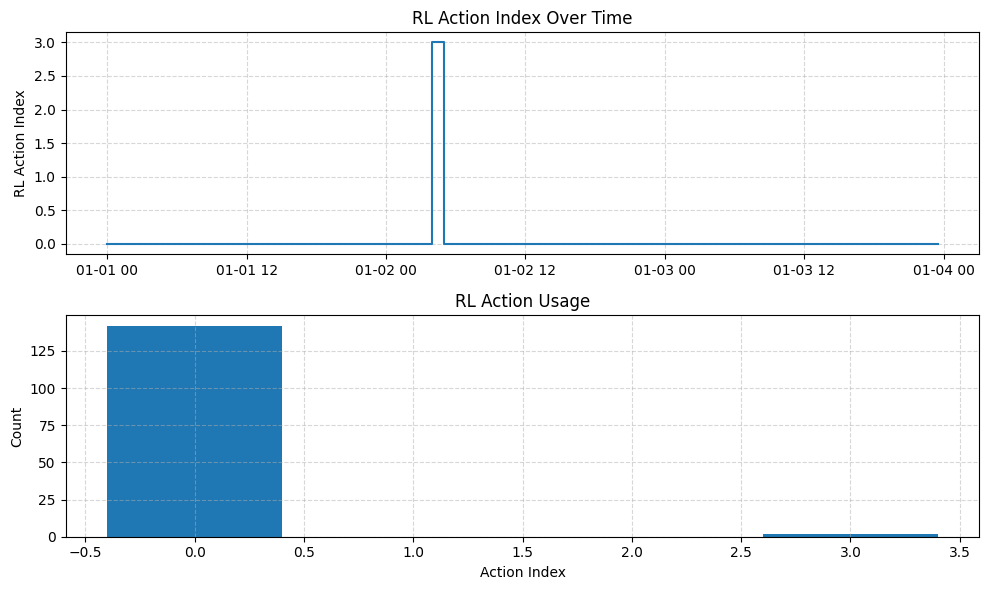


Action index → setpoint mapping:
  0 → 20.0 °C
  3 → 21.5 °C

Action counts:
  index 0 (20.0 °C): 142 steps
  index 3 (21.5 °C): 2 steps


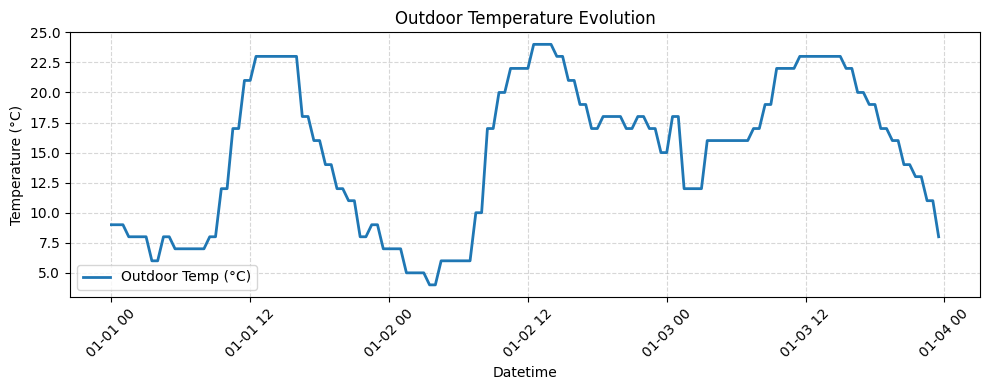

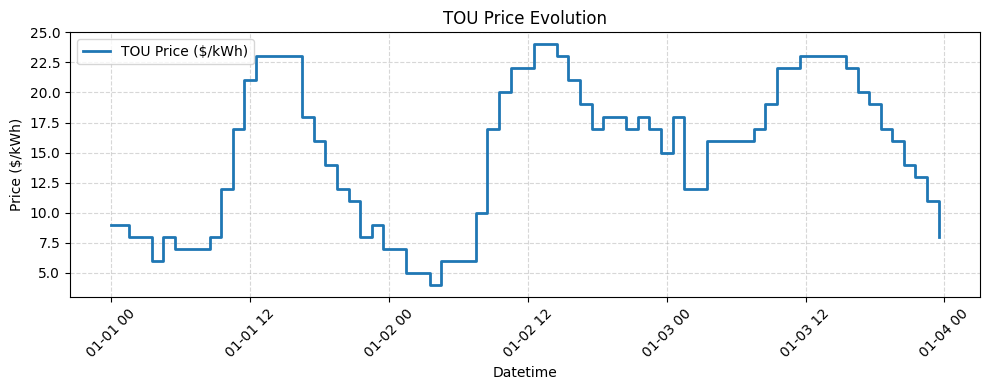

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ===========================
# Helpers
# ===========================
def safe_datetime(info, t, start="2018-01-01", minutes=30):
    dt = info.get("Datetime", None) if isinstance(info, dict) else None
    if dt is None:
        return pd.Timestamp(start) + pd.Timedelta(minutes=minutes * t)
    if isinstance(dt, str):
        dt = pd.to_datetime(dt)
    return dt

def extract_indoor_temp(obs, info):
    if isinstance(info, dict) and ("Temperature - Indoor (C)" in info):
        return float(info["Temperature - Indoor (C)"])
    obs = np.asarray(obs).ravel()
    return float(obs[0])

def extract_outdoor_temp(obs, info):
    """Prefer outdoor temp from info; otherwise fall back to obs[1]."""
    if isinstance(info, dict) and ("Temperature - Outdoor (C)" in info):
        return float(info["Temperature - Outdoor (C)"])
    obs = np.asarray(obs).ravel()
    return float(obs[1]) if obs.size >= 2 else np.nan

def extract_obs_components(obs):
    """Assumes override order: [Tin, Tout, Price, Hour]. Falls back gracefully."""
    obs = np.asarray(obs).ravel()
    tin  = float(obs[0]) if obs.size >= 1 else np.nan
    tout = float(obs[1]) if obs.size >= 2 else np.nan
    price= float(obs[2]) if obs.size >= 3 else np.nan
    hour = float(obs[3]) if obs.size >= 4 else np.nan
    return tin, tout, price, hour

def get_comfort_band(env, default=(20.0, 23.0)):
    for attr in ("thermal_comfort_band", "comfort_band", "comfort_range"):
        if hasattr(env, attr):
            band = getattr(env, attr)
            if isinstance(band, (list, tuple)) and len(band) == 2:
                return float(band[0]), float(band[1])
    inner = getattr(env, "env", None)
    if inner is not None:
        for attr in ("thermal_comfort_band", "comfort_band", "comfort_range"):
            if hasattr(inner, attr):
                band = getattr(inner, attr)
                if isinstance(band, (list, tuple)) and len(band) == 2:
                    return float(band[0]), float(band[1])
    return default

# ===========================
# Evaluations with action logging
# ===========================
def evaluate_policy_with_actions(env, Q, SETPOINTS, max_steps=2000):
    data = []
    obs, info = env.reset()
    s = discretize_safe(obs, info)
    for t in range(max_steps):
        a = int(np.argmax(Q[s]))  # greedy
        obs, r, terminated, truncated, info = env.step(a)
        s = discretize_safe(obs, info)
        tin, tout, price, hour = extract_obs_components(obs)
        data.append({
            "Datetime": safe_datetime(info, t),
            "ActionIdx_RL": a,
            "Setpoint_RL": float(SETPOINTS[a]),
            "IndoorTemp_RL": extract_indoor_temp(obs, info),
            "OutdoorTemp_RL": extract_outdoor_temp(obs, info),  # <-- added
            "Tout": tout,
            "Price": price,
            "Hour": hour
        })
        if terminated or truncated:
            break
    return pd.DataFrame(data)

def evaluate_baseline(env, SETPOINTS, fixed_setpoint=21.5, max_steps=2000):
    data = []
    fixed_idx = int(np.argmin(np.abs(np.array(SETPOINTS) - fixed_setpoint)))
    obs, info = env.reset()
    for t in range(max_steps):
        obs, r, terminated, truncated, info = env.step(fixed_idx)
        tin, tout, price, hour = extract_obs_components(obs)
        data.append({
            "Datetime": safe_datetime(info, t),
            "ActionIdx_Base": fixed_idx,
            "Setpoint_Baseline": float(SETPOINTS[fixed_idx]),
            "IndoorTemp_Baseline": extract_indoor_temp(obs, info),
            "OutdoorTemp_Base": extract_outdoor_temp(obs, info),  # <-- added
            "Tout": tout,
            "Price": price,
            "Hour": hour
        })
        if terminated or truncated:
            break
    return pd.DataFrame(data)

# ===========================
# Run and align
# ===========================
rl_df   = evaluate_policy_with_actions(env, Q, SETPOINTS)
# ---- ONLY CHANGE: set baseline to 21.0°C ----
base_df = evaluate_baseline(env, SETPOINTS, fixed_setpoint=21.0)

merged = pd.merge_asof(
    rl_df.sort_values("Datetime"),
    base_df.sort_values("Datetime"),
    on="Datetime",
    direction="nearest"
)

# Comfort band (variables from env)
COMFORT_LOW, COMFORT_HIGH = get_comfort_band(env)

# ===========================
# Figure 1: Temps & Setpoints (styles per your spec)
# ===========================
plt.figure(figsize=(10, 5))

plt.plot(merged["Datetime"], merged["Setpoint_RL"],        color="black",  linestyle="-",  linewidth=2, label="RL Setpoint (°C)")
plt.plot(merged["Datetime"], merged["Setpoint_Baseline"],  color="black",  linestyle="--", linewidth=2, label="Baseline Setpoint (°C)")

plt.plot(merged["Datetime"], merged["IndoorTemp_RL"],       color="magenta", linestyle="-",  alpha=0.9, label="RL Indoor Temp (°C)")
plt.plot(merged["Datetime"], merged["IndoorTemp_Baseline"], color="magenta", linestyle="--", alpha=0.9, label="Baseline Indoor Temp (°C)")

plt.hlines(COMFORT_LOW,  merged["Datetime"].iloc[0], merged["Datetime"].iloc[-1],
           colors="blue", linestyles=":", linewidth=2, label=f"Lower Comfort ({COMFORT_LOW} °C)")
plt.hlines(COMFORT_HIGH, merged["Datetime"].iloc[0], merged["Datetime"].iloc[-1],
           colors="red",  linestyles=":", linewidth=2, label=f"Upper Comfort ({COMFORT_HIGH} °C)")

plt.xlabel("Datetime")
plt.ylabel("Temperature (°C)")
plt.title("Indoor Temperature & Setpoint: RL (solid) vs Baseline (dashed)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ===========================
# Figure 2: RL action index over time + histogram
# ===========================
fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=False)

ax[0].step(rl_df["Datetime"], rl_df["ActionIdx_RL"], where="post")
ax[0].set_ylabel("RL Action Index")
ax[0].set_title("RL Action Index Over Time")
ax[0].grid(True, linestyle="--", alpha=0.5)

counts = rl_df["ActionIdx_RL"].value_counts().sort_index()
ax[1].bar(counts.index.astype(int), counts.values)
ax[1].set_xlabel("Action Index")
ax[1].set_ylabel("Count")
ax[1].set_title("RL Action Usage")
ax[1].grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# ===========================
# Print mapping and counts
# ===========================
unique_actions = sorted(rl_df["ActionIdx_RL"].unique().tolist())
print("\nAction index → setpoint mapping:")
for idx in unique_actions:
    print(f"  {idx} → {SETPOINTS[idx]:.1f} °C")

print("\nAction counts:")
for idx in unique_actions:
    print(f"  index {idx} ({SETPOINTS[idx]:.1f} °C): {int((rl_df['ActionIdx_RL']==idx).sum())} steps")

# ===========================
# Figure 3: Outdoor temperature evolution (corrected)
# ===========================
tout_series = merged.get("OutdoorTemp_RL", rl_df.get("OutdoorTemp_RL"))
if tout_series is None or len(tout_series) == 0:
    tout_series = merged.get("OutdoorTemp_Base", base_df.get("OutdoorTemp_Base"))

plt.figure(figsize=(10, 4))
plt.plot(merged["Datetime"], tout_series, linewidth=2, label="Outdoor Temp (°C)")
plt.xlabel("Datetime")
plt.ylabel("Temperature (°C)")
plt.title("Outdoor Temperature Evolution")
plt.grid(True, linestyle="--", alpha=0.5)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# ===========================
# Figure 4: TOU price evolution (step plot)
# ===========================
if "Price_x" in merged.columns:
    price_series = merged["Price_x"]
elif "Price" in merged.columns:
    price_series = merged["Price"]
else:
    price_series = merged.get("Price_y", pd.Series(index=merged.index, dtype=float))

plt.figure(figsize=(10, 4))
plt.step(merged["Datetime"], price_series, where="post", linewidth=2, label="TOU Price ($/kWh)")
plt.xlabel("Datetime")
plt.ylabel("Price ($/kWh)")
plt.title("TOU Price Evolution")
plt.grid(True, linestyle="--", alpha=0.5)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


=== RL setpoint/action changes ===
           Datetime Setpoint prev→new Action prev→new Tin (°C) Tout (°C) Price Hour Bins changed
2018-01-02 04:00:00         20.0→21.5             0→3    21.65     21.65 4.000  nan    [Tin_bin]
2018-01-02 05:00:00         21.5→20.0             3→0    20.85     20.85 6.000  nan    [Tin_bin]


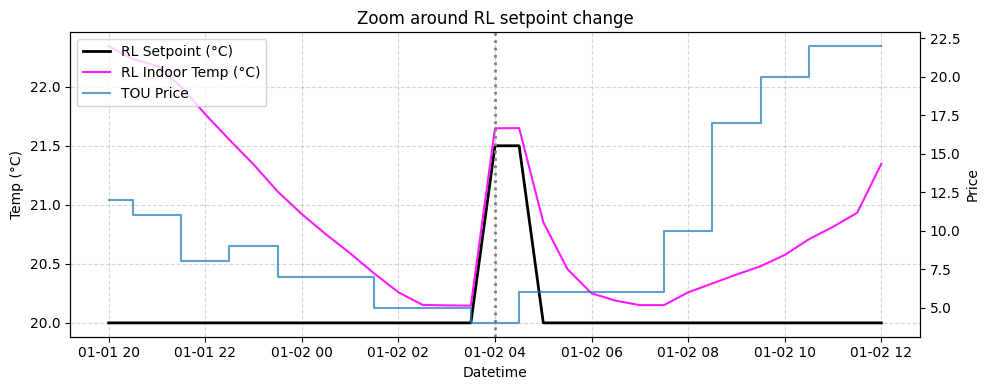

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- helpers ----
def pick(df, *cands):
    """Return the first existing column among candidates; else raise."""
    for c in cands:
        if c in df.columns:
            return c
    raise KeyError(f"None of {cands} found in dataframe columns: {list(df.columns)}")

def bin_series(values, edges):
    # np.digitize returns 1..len(edges); clamp to [0, len(edges)]
    i = np.digitize(values, edges, right=False).astype(int)
    return np.clip(i, 0, len(edges))

# ---- map your logged columns (IndoorTemp_RL etc.) to generic names ----
TIN_COL    = pick(rl_df, "Tin", "IndoorTemp_RL", "IndoorTemp")         # <- your data has "IndoorTemp_RL"
TOUT_COL   = pick(rl_df, "Tout", "OutdoorTemp_RL", "OutdoorTemp")
PRICE_COL  = pick(rl_df, "Price", "Price_RL")
HOUR_COL   = pick(rl_df, "Hour")
ACT_COL    = pick(rl_df, "ActionIdx_RL", "Action")                     # action index chosen by RL
SP_COL     = pick(rl_df, "Setpoint_RL", "Setpoint")
TIME_COL   = pick(rl_df, "Datetime", "time", "timestamp")

# ---- build a tidy frame with bins and features ----
rl_bins = pd.DataFrame({
    "Datetime": rl_df[TIME_COL].values,
    "Tin":      rl_df[TIN_COL].astype(float).values,
    "Tout":     rl_df[TOUT_COL].astype(float).values,
    "Price":    rl_df[PRICE_COL].astype(float).values,
    "Hour":     rl_df[HOUR_COL].astype(float).values,
    "Action":   rl_df[ACT_COL].astype(int).values,
    "Setpoint": rl_df[SP_COL].astype(float).values,
})
rl_bins["Tin_bin"]   = bin_series(rl_bins["Tin"].values,   BIN_EDGES[0])
rl_bins["Tout_bin"]  = bin_series(rl_bins["Tout"].values,  BIN_EDGES[1])
rl_bins["Price_bin"] = bin_series(rl_bins["Price"].values, BIN_EDGES[2])
rl_bins["Hour_bin"]  = bin_series(rl_bins["Hour"].values,  BIN_EDGES[3])

# ---- find action changes (the "spikes") ----
changes = rl_bins[rl_bins["Action"].diff().fillna(0) != 0].copy()
prev = rl_bins.shift(1).loc[changes.index]
changes["Datetime_prev"] = prev["Datetime"].values
changes["Action_prev"]   = prev["Action"].values
changes["Setpoint_prev"] = prev["Setpoint"].values

for col in ["Tin_bin","Tout_bin","Price_bin","Hour_bin"]:
    changes[f"{col}_changed"] = (rl_bins[col].diff().fillna(0) != 0).loc[changes.index].values

def which_changed(row):
    out = []
    if row["Tin_bin_changed"]:   out.append("Tin_bin")
    if row["Tout_bin_changed"]:  out.append("Tout_bin")
    if row["Price_bin_changed"]: out.append("Price_bin")
    if row["Hour_bin_changed"]:  out.append("Hour_bin")
    return out

summary = []
for _, r in changes.iterrows():
    summary.append({
        "Datetime": r["Datetime"],
        "Setpoint prev→new": f"{r['Setpoint_prev']:.1f}→{r['Setpoint']:.1f}",
        "Action prev→new":   f"{int(r['Action_prev'])}→{int(r['Action'])}",
        "Tin (°C)":          f"{r['Tin']:.2f}",
        "Tout (°C)":         f"{r['Tout']:.2f}",
        "Price":             f"{r['Price']:.3f}",
        "Hour":              f"{r['Hour']:.0f}",
        "Bins changed":      which_changed(r)
    })

spike_report = pd.DataFrame(summary)
print("=== RL setpoint/action changes ===")
print(spike_report.to_string(index=False) if not spike_report.empty else "No changes detected.")

# ---- zoom plot around the first spike ----
if not spike_report.empty:
    first_idx = changes.index[0]
    N = 16  # window half-width in steps
    lo = max(0, first_idx - N)
    hi = min(len(rl_bins)-1, first_idx + N)
    zoom = rl_bins.loc[lo:hi].copy()

    fig, ax1 = plt.subplots(figsize=(10,4))
    ax1.plot(zoom["Datetime"], zoom["Setpoint"], color="black", label="RL Setpoint (°C)", linewidth=2)
    ax1.plot(zoom["Datetime"], zoom["Tin"], color="magenta", alpha=0.9, label="RL Indoor Temp (°C)")
    ax1.set_xlabel("Datetime"); ax1.set_ylabel("Temp (°C)")
    ax1.grid(True, linestyle="--", alpha=0.5)

    ax2 = ax1.twinx()
    ax2.step(zoom["Datetime"], zoom["Price"], where="post", alpha=0.7, label="TOU Price")
    ax2.set_ylabel("Price")

    ax1.axvline(rl_bins.loc[first_idx, "Datetime"], color="gray", linestyle=":", linewidth=2)

    l1, lab1 = ax1.get_legend_handles_labels()
    l2, lab2 = ax2.get_legend_handles_labels()
    ax1.legend(l1+l2, lab1+lab2, loc="upper left")

    plt.title("Zoom around RL setpoint change")
    plt.tight_layout()
    plt.show()


In [8]:
# from stable_baselines3 import DQN
# model = DQN("MlpPolicy", env, learning_rate=1e-4, buffer_size=100_000, verbose=1)
# model.learn(total_timesteps=400_000)
